In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle

In [2]:
from STDP_helper import *

# Visualize some STDP features
Code partially adapted from https://compneuro.neuromatch.io/tutorials/W2D3_BiologicalNeuronModels/student/W2D3_Tutorial4.html


## STDP kernel

In [3]:
def Delta_W(pars, A_plus, A_minus, tau_stdp):
    
    """
    Plot STDP biphasic exponential decaying function

  Args:
    pars       : parameter dictionary
    A_plus     : (float) maximum amount of synaptic modification
                 which occurs when the timing difference between pre- and
                 post-synaptic spikes is positive
    A_minus    : (float) maximum amount of synaptic modification
                 which occurs when the timing difference between pre- and
                 post-synaptic spikes is negative
    tau_stdp   : the ranges of pre-to-postsynaptic interspike intervals
                 over which synaptic strengthening or weakening occurs

  Returns:
    dW         : instantaneous change in weights
  """

    # STDP change
    dW = np.zeros(len(time_diff))  # time_diff = t_pre - t_post
    # Calculate dW for LTP
    dW[time_diff <= 0] = A_plus * np.exp(time_diff[time_diff <= 0] / tau_stdp)
    # Calculate dW for LTD
    dW[time_diff > 0] = -A_minus * np.exp(-time_diff[time_diff > 0] / tau_stdp)
    return dW

In [4]:
pars = default_pars_STDP()
# Get parameters
A_plus, A_minus, tau_stdp = pars['A_plus'], pars['A_minus'], pars['tau_stdp']
# pre_spike time - post_spike time
time_diff = np.linspace(-5 * tau_stdp, 5 * tau_stdp, 100)

dW = Delta_W(pars, A_plus, A_minus, tau_stdp)

In [5]:
def plot_STDP_kernel(A_plus, A_minus, tau_stdp, time_diff, dW):
    fig, ax = plt.subplots()
    ax.plot([-5 * tau_stdp, 5 * tau_stdp], [0, 0], 'grey', linestyle='-', linewidth=1)
    ax.plot([0, 0], [-A_minus, A_plus], 'grey', linestyle='-', linewidth=1)

    ax.plot(time_diff[time_diff <= 0], dW[time_diff <= 0], 'k-', linewidth=3)
    ax.plot(time_diff[time_diff > 0], dW[time_diff > 0], 'k-', linewidth=3)
    
    ax.spines[['top', 'right']].set_visible(False)
    ax.tick_params(axis='x', which='major', labelsize=24)
    ax.tick_params(axis='y', which='major', labelsize=24)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)

    plt.xlabel(r't$_{\mathrm{pre}}$ - t$_{\mathrm{post}}$ (ms)', fontsize=24)
    plt.ylabel(r'$\Delta$W', fontsize=24)
    plt.title('STDP kernel', fontsize=30)
    plt.show()

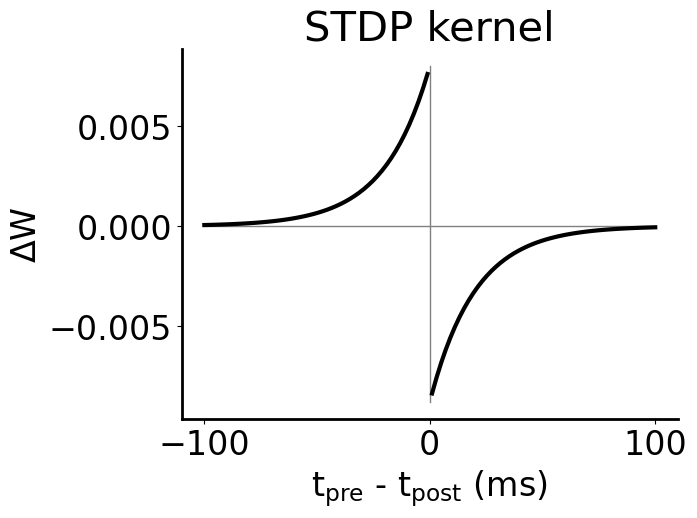

In [6]:
plot_STDP_kernel(A_plus, A_minus, tau_stdp, time_diff, dW)

## Pre-synaptic spike trains

In [7]:
pars = default_pars_STDP(T=100000, dt=1.)  # Simulation duration 100000 ms
pars['gE_bar'] = 0.024  # max synaptic conductance
pars['gE_init'] = 0.014  # initial synaptic conductance
pars['VE'] = 0.  # [mV] Synapse reversal potential
pars['tau_syn_E'] = 5.  # [ms] EPSP time constant

# generate Poisson type spike trains
pre_spike_train_ex = Poisson_generator(pars, rate=50, n=100, myseed=2020)  # pre_spike_train_ex: (npresyn, totalsteps)
# simulate the LIF neuron and record the synaptic conductance
v, rec_spikes, gE, P, M, gE_bar_update = run_LIF_cond_STDP(pars,
                                                           pre_spike_train_ex)

In [8]:
pre_spike_train_ex.shape

(100, 100000)

In [9]:
dt, range_t = pars['dt'], pars['range_t']

In [10]:
dt, range_t[0], range_t[-1]

(1.0, 0.0, 99999.0)

In [11]:
def plot_spike_raster(range_t, spike_train, n):
    fig, ax = plt.subplots()
    # Raster plot
    i = 0
    while i < n:
        if spike_train[i, :].sum() > 0.:
            t_sp = range_t[spike_train[i, :] > 0.5]  # spike times
            ax.plot(t_sp, i * np.ones(len(t_sp)), '|', c='grey', ms=10, markeredgewidth=3)
        i += 1
    ax.set_xlim([range_t[0], range_t[-1]+10])
    ax.set_ylim([-0.5, n])
    ax.set_yticks(np.arange(n))
    ax.set_yticklabels(np.arange(1, 1+n))
    
    ax.spines[['top', 'right']].set_visible(False)
    ax.tick_params(axis='x', which='major', labelsize=24)
    ax.tick_params(axis='y', which='major', labelsize=24)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    
    ax.set_xlabel('Time (ms)', fontsize=24)
    ax.set_ylabel('Synapse id', fontsize=24)
    
    plt.show()

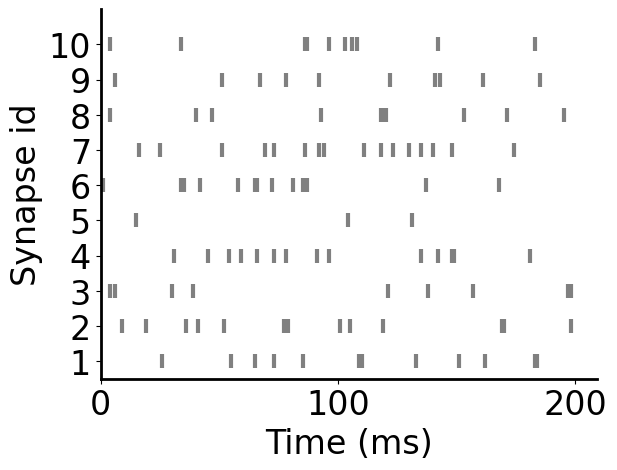

In [12]:
plot_spike_raster(pars['range_t'][:200], pre_spike_train_ex[:,:200], 10)

## Synaptic weight evolution

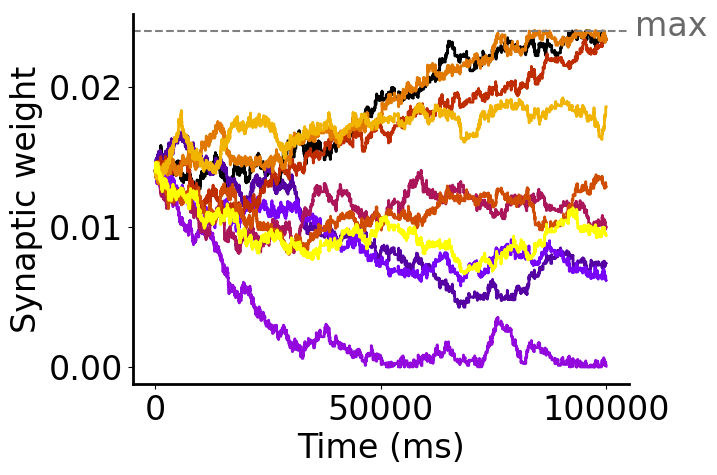

In [13]:
fig, ax = plt.subplots()

cmap = plt.get_cmap('gnuplot')

# Generate 10 colors evenly spaced from the colormap
colors = cmap(np.linspace(0, 1, 10))

# Plot each line with a color from the colormap
for i, color in enumerate(colors):
    ax.plot(pars['range_t'], gE_bar_update[i, :], linewidth=2, color=color)

ax.axhline(y=pars['gE_bar'], color='grey', linestyle='--')
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(axis='x', which='major', labelsize=24)
ax.tick_params(axis='y', which='major', labelsize=24)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

ax.set_xlabel('Time (ms)', fontsize=24)
ax.set_ylabel('Synaptic weight', fontsize=24)

fig.text(0.91, 0.835, 'max', color='dimgray', fontsize=24)
plt.show()

# Visualize NetFormer results

In [14]:
resdir = 'results/totalsteps100000_npre100_rate50_histlen5_standardize1_embdim101_projdim0_maxepoch20_batchsize64_lr0.005_smoothlen10000_lrschr0/'

In [15]:
attn_allsteps_seed0 = np.load(resdir + 'attn_allsteps_seed0.npy')
print(attn_allsteps_seed0.shape)

(100, 99995)


In [16]:
gE_bar_allsteps = np.load(resdir + 'gE_bar.npy')
print(gE_bar_allsteps.shape)

(100, 99995)


In [17]:
def smooth(y, box_pts):
    if len(y.shape) == 2:
        cumsum_y = np.cumsum(np.insert(y, 0, 0, axis=1), axis=1)
        return (cumsum_y[:, box_pts:] - cumsum_y[:, :-box_pts])/box_pts
    else:
        cumsum_y = np.cumsum(np.insert(y, 0, 0))
        return (cumsum_y[box_pts:] - cumsum_y[:-box_pts])/box_pts

In [18]:
gE_bar_smooth_allsteps = smooth(gE_bar_allsteps, 10000)
print(gE_bar_smooth_allsteps.shape)

(100, 89996)


In [19]:
attn_smooth_allsteps_seed0 = smooth(attn_allsteps_seed0, 10000)
print(attn_smooth_allsteps_seed0.shape)

(100, 89996)


In [20]:
ccs = [np.corrcoef(attn_smooth_allsteps_seed0[i], gE_bar_smooth_allsteps[i])[0, 1] for i in range(100)]

In [21]:
sorted_indices = np.argsort(ccs)[::-1]

In [22]:
sorted_ccs = np.array(ccs)[sorted_indices]

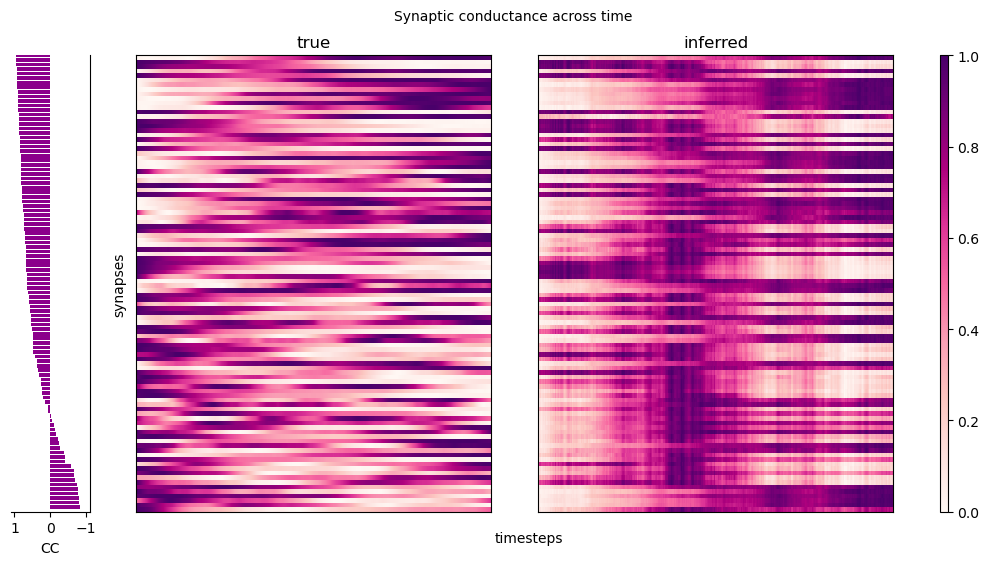

In [23]:
fig = plt.figure(figsize=(10, 5.5)) 
gs = fig.add_gridspec(1, 4, width_ratios=[1, 4.5, 4.5, 0.1])

ax1 = fig.add_subplot(gs[0])

y_positions = np.arange(100)
ax1.barh(y_positions, sorted_ccs, align='center', color='darkmagenta')
ax1.set_ylim((0, 100))
ax1.set_xlim((-1.1, 1.1))
ax1.invert_yaxis()

# Invert x-axis to make bars go from right to left
ax1.invert_xaxis()
ax1.set_xlabel('CC')
ax1.set_yticks([])
ax1.spines[['left', 'top']].set_visible(False)

ax2 = fig.add_subplot(gs[1])
gE_bar_smooth_allsteps1 = gE_bar_smooth_allsteps[sorted_indices]
row_min = gE_bar_smooth_allsteps1.min(axis=1, keepdims=True)
row_max = gE_bar_smooth_allsteps1.max(axis=1, keepdims=True)
normalized = (gE_bar_smooth_allsteps1 - row_min) / (row_max - row_min)
ax2.imshow(normalized, aspect='auto', interpolation='none', cmap='RdPu', vmax=1, vmin=0)
ax2.set_ylabel('synapses')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('true')

ax3 = fig.add_subplot(gs[2])
attn_smooth_allsteps_seed0_1 = attn_smooth_allsteps_seed0[sorted_indices]
row_min = attn_smooth_allsteps_seed0_1.min(axis=1, keepdims=True)
row_max = attn_smooth_allsteps_seed0_1.max(axis=1, keepdims=True)
normalized = (attn_smooth_allsteps_seed0_1 - row_min) / (row_max - row_min)
im = ax3.imshow(normalized, aspect='auto', interpolation='none', cmap='RdPu', vmax=1, vmin=0)

ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('inferred')

cbar_ax = fig.add_subplot(gs[3])
fig.colorbar(im, cax=cbar_ax)

fig.text(0.5, 0.05, 'timesteps')
fig.text(0.4, 1, 'Synaptic conductance across time')
plt.tight_layout()
plt.show()

In [24]:
sorted_indices

array([73, 76, 36, 72, 74, 35, 93, 48, 24, 51, 25, 43, 46, 53, 94, 34, 10,
       82, 75, 79, 27, 77, 32, 99, 78, 55, 17, 85, 65,  5, 20, 52, 16, 68,
       95, 67,  8, 64,  2, 61, 71, 98, 87, 90, 22, 41, 81,  3, 89,  0, 23,
       19, 97, 15, 29, 21, 38, 45, 88, 31, 30, 54, 59,  1, 12, 44, 33, 86,
        7,  9, 58, 39, 66, 70, 47, 96, 60, 49, 26,  4, 14, 13,  6, 83, 69,
       28, 18, 11, 40, 91, 57, 42, 92, 37, 80, 84, 56, 63, 50, 62])

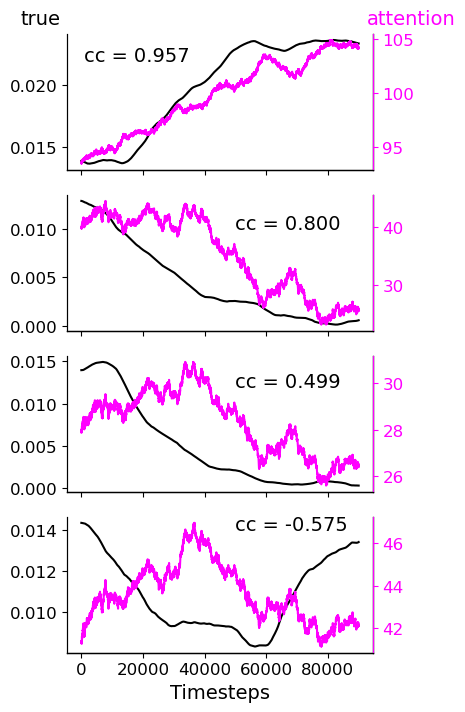

In [25]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(4.5, 1.75*4))
ixs = [0, 30, 60, 90]
fs = 14
c = 'magenta'

ax = axes[0]
gE_smooth = smooth(gE_bar_allsteps[sorted_indices[ixs[0]]], 10000)
ai_smooth = smooth(attn_allsteps_seed0[sorted_indices[ixs[0]]], 10000)
ax.plot(gE_smooth, 'k')
ax_ = ax.twinx()
ax_.plot(ai_smooth, color=c)
cc = np.corrcoef(gE_smooth, ai_smooth)[0, 1]

ax.text(1000, 0.022, f'cc = {cc:.3f}', fontsize=fs)
ax_.spines['right'].set_color(c) 
ax_.tick_params(axis='y', colors=c)
ax_.yaxis.label.set_color(c)
ax.spines[['top']].set_visible(False)
ax_.spines[['top']].set_visible(False)
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)
ax_.tick_params(axis='y', which='major', labelsize=12)
ax.spines['bottom'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)

ax = axes[1]
gE_smooth = smooth(gE_bar_allsteps[sorted_indices[ixs[1]]], 10000)
ai_smooth = smooth(attn_allsteps_seed0[sorted_indices[ixs[1]]], 10000)
ax.plot(gE_smooth, 'k')
ax_ = ax.twinx()
ax_.plot(ai_smooth, color=c)
cc = np.corrcoef(gE_smooth, ai_smooth)[0, 1]

ax.text(50000, 0.01, f'cc = {cc:.3f}', fontsize=fs)
ax_.spines['right'].set_color(c) 
ax_.tick_params(axis='y', colors=c)
ax_.yaxis.label.set_color(c)
ax.spines[['top']].set_visible(False)
ax_.spines[['top']].set_visible(False)
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)
ax_.tick_params(axis='y', which='major', labelsize=12)
ax.spines['bottom'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)

ax = axes[2]
gE_smooth = smooth(gE_bar_allsteps[sorted_indices[ixs[2]]], 10000)
ai_smooth = smooth(attn_allsteps_seed0[sorted_indices[ixs[2]]], 10000)
ax.plot(gE_smooth, 'k')
ax_ = ax.twinx()
ax_.plot(ai_smooth, color=c)
cc = np.corrcoef(gE_smooth, ai_smooth)[0, 1]

ax.text(50000, 0.012, f'cc = {cc:.3f}', fontsize=fs)
ax_.spines['right'].set_color(c) 
ax_.tick_params(axis='y', colors=c)
ax_.yaxis.label.set_color(c)
ax.spines[['top']].set_visible(False)
ax_.spines[['top']].set_visible(False)
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)
ax_.tick_params(axis='y', which='major', labelsize=12)
ax.spines['bottom'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)

ax = axes[3]
gE_smooth = smooth(gE_bar_allsteps[sorted_indices[ixs[3]]], 10000)
ai_smooth = smooth(attn_allsteps_seed0[sorted_indices[ixs[3]]], 10000)
ax.plot(gE_smooth, 'k')
ax_ = ax.twinx()
ax_.plot(ai_smooth, color=c)
cc = np.corrcoef(gE_smooth, ai_smooth)[0, 1]

ax.text(50000, 0.014, f'cc = {cc:.3f}', fontsize=fs)
ax_.spines['right'].set_color(c) 
ax_.tick_params(axis='y', colors=c)
ax_.yaxis.label.set_color(c)
ax.spines[['top']].set_visible(False)
ax_.spines[['top']].set_visible(False)
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)
ax_.tick_params(axis='y', which='major', labelsize=12)
ax.spines['bottom'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)

ax.set_xlabel('Timesteps', fontsize=14)
# ax.set_ylabel(r'$\bar{g}_i$ smoothed')
# ax_.set_ylabel(r'$a_i$ smoothed')

fig.text(0.08, 0.99, 'true', fontsize=fs)
fig.text(0.85, 0.99, 'attention', fontsize=fs, color=c)


plt.tight_layout()
plt.show()

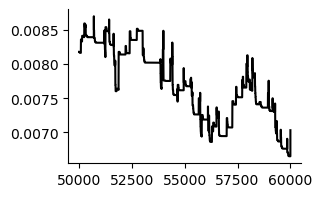

In [26]:
fig, ax = plt.subplots(figsize=(3, 2))
win = np.r_[50000:60000]
ax.plot(win, gE_bar_allsteps[1, win], 'k')
ax.spines[['top', 'right']].set_visible(False)
plt.show()

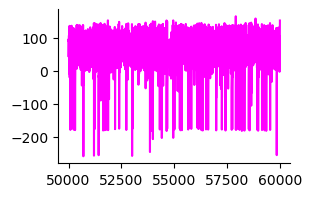

In [27]:
fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(win, attn_allsteps_seed0[1][win], 'magenta')
ax.spines[['top', 'right']].set_visible(False)
plt.show()

# Compare with linear regression

In [28]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [29]:
def align_with_hist(curr_inputs, nhist):
    # curr_inputs: (nsamples, nvar, 1). return: res: (nsamples-nhist, nvar, nhist+1)
    # res[:, :, -1] store the most recent timesteps
    res = [curr_inputs]
    for i in range(1, nhist + 1):
        inputs1 = np.roll(curr_inputs, -i, 0)
        res.append(inputs1)
    res = np.concatenate(res, axis=-1)
    return res[:curr_inputs.shape[0]-nhist]

In [30]:
###### simulate data #####
totalsteps = 100000
rate = 50
npre = 100
histlen = 5
standardize = 1

pars = default_pars_STDP(T=totalsteps, dt=1.)  # Simulation duration 200 ms
pars['gE_bar'] = 0.024  # max synaptic conductance
pars['gE_init'] = 0.014  # initial synaptic conductance
pars['VE'] = 0.  # [mV] Synapse reversal potential
pars['tau_syn_E'] = 5.  # [ms] EPSP time constant

# generate Poisson type spike trains
pre_spike_train_ex = Poisson_generator(pars, rate=rate, n=npre, myseed=2020)  # pre_spike_train_ex: (npre, totalsteps)
# simulate the LIF neuron and record the synaptic conductance
v, rec_spikes, gE, P, M, gE_bar_update = run_LIF_cond_STDP(pars, pre_spike_train_ex)  # v: (totalsteps, )

##### generate training/test samples #####
ntrain = int(totalsteps*0.8)
if standardize:
    v_train_mean = np.mean(v[:ntrain])
    v_train_std = np.std(v[:ntrain])
    v = (v - v_train_mean)/v_train_std
v_train = v[:ntrain]
v_test = v[ntrain-histlen:]

pre_spk_train = pre_spike_train_ex[:, :ntrain]
pre_spk_test = pre_spike_train_ex[:, ntrain-histlen:]

x_train = np.vstack((v_train, pre_spk_train)).T  # (ntrain, 1+npre)
x_train = np.expand_dims(x_train, axis=-1)  # (ntrain, 1+npre, 1)
x_train_align = align_with_hist(x_train, histlen)
x_train_tag = x_train_align[:, 0, -1]  # training targets
x_train_inp = x_train_align[:, :, :-1]  # training inputs
assert np.sum(np.abs(x_train_tag - v_train[histlen:])) == 0
del x_train_align

x_test = np.vstack((v_test, pre_spk_test)).T
x_test = np.expand_dims(x_test, axis=-1)
x_test_align = align_with_hist(x_test, histlen)
x_test_tag = x_test_align[:, 0, -1]  # test targets
x_test_inp = x_test_align[:, :, :-1]  # test inputs
assert np.sum(np.abs(x_test_tag - v[ntrain:])) == 0
del x_test_align

print(x_train_inp.shape, x_train_tag.shape, x_test_inp.shape, x_test_tag.shape)

(79995, 101, 5) (79995,) (20000, 101, 5) (20000,)


In [31]:
x_train_inp_flat = x_train_inp.reshape((x_train_inp.shape[0], -1))
x_test_inp_flat = x_test_inp.reshape((x_test_inp.shape[0], -1))
print(x_train_inp_flat.shape, x_test_inp_flat.shape)

(79995, 505) (20000, 505)


In [32]:
A_ols = np.linalg.inv(x_train_inp_flat.T @ x_train_inp_flat) @ x_train_inp_flat.T @ x_train_tag.reshape((-1, 1))

In [33]:
A_ols.shape

(505, 1)

In [34]:
A_ols_avg = np.mean(np.abs(A_ols[5:]).reshape(-1, 5), axis=1)

In [35]:
A_ols_avg.shape

(100,)

In [36]:
test_pred = x_test_inp_flat @ A_ols

In [37]:
mean_squared_error(x_test_tag, test_pred.ravel())

0.1380763930979782

In [38]:
r2_score(x_test_tag, test_pred.ravel())

0.7765760965519722

In [39]:
test_pred_seed0 = np.load(resdir + 'test_pred_seed0.npy')

In [40]:
test_target = np.load(resdir + 'test_target.npy')

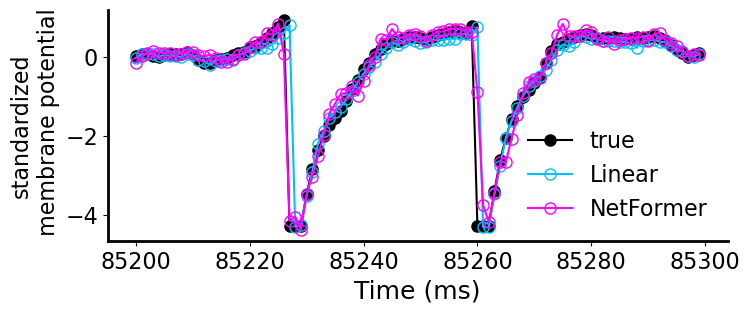

In [41]:
fig, ax = plt.subplots(figsize=(8, 3))

test_times = np.arange(100000)[int(100000*0.8):]
win = np.r_[5200:5300]
ax.plot(test_times[win], test_target[win], '-ko', ms=8, label='true')
ax.plot(test_times[win], test_pred.ravel()[win], '-o', color='deepskyblue', ms=8, markerfacecolor='none', label='Linear')
ax.plot(test_times[win], test_pred_seed0[win], '-o', color='magenta', ms=8, markerfacecolor='none', label='NetFormer')
ax.set_xlabel('Time (ms)', fontsize=18)

ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

ax.set_ylabel('standardized\n membrane potential', fontsize=16)


ax.legend(fontsize=16, frameon=False, labelspacing=0.5)
plt.show()

# NetFormer results of 5 seeds

In [42]:
with open(resdir+'final_scores.pkl', 'rb') as f:
    final_scores = pickle.load(f)

In [43]:
final_scores['test_mse_allseeds']

{0: 0.05429888889193535,
 1: 0.05096074938774109,
 2: 0.04297158494591713,
 3: 0.066522978246212,
 4: 0.05818341672420502}

In [44]:
final_scores['test_r2_allseeds']

{0: 0.9121379899301206,
 1: 0.9175394958329214,
 2: 0.9304669008740508,
 3: 0.8923579705241115,
 4: 0.9058523725692291}

In [45]:
for s in range(5):
    print(s, np.median(final_scores['ccs_allseeds'][s]))

0 0.6561020484026525
1 0.621691415727469
2 0.5914949708005223
3 0.5940941462942644
4 0.5767224737314165
